In [1]:
import gc
import os

import pandas as pd
import numpy as np

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, classification_report

random_state = 42

In [2]:
print(os.getcwd())

c:\Users\erich\Desktop\HYU\신용카드 고객 세그먼트 분류 공모전\eda


### 데이터셋 로드

In [3]:
# train_set 준비

months = [7, 8, 9, 10, 11, 12]

trains = []

drop_columns = [
    'ID',
    # 'index',
    '기준년월',
    # '상품관련면제카드수_B0M',
    # '임직원면제카드수_B0M',
    # '우수회원면제카드수_B0M',
    # '기타면제카드수_B0M',
    '카드신청건수',
    '이용금액_R3M_체크',
    '이용금액_R3M_체크_가족',
    '유효카드수_체크',
    '유효카드수_체크_가족',
    '이용가능카드수_체크',
    '이용가능카드수_체크_가족',
    '이용카드수_체크',
    '이용카드수_체크_가족',
    '연회비발생카드수_B0M',
    '연회비할인카드수_B0M',
    '기본연회비_B0M',
    '제휴연회비_B0M',
    '할인금액_기본연회비_B0M',
    '할인금액_제휴연회비_B0M',
    '청구금액_기본연회비_B0M',
    '청구금액_제휴연회비_B0M',
    # '캠페인접촉건수_R12M',
    # '캠페인접촉일수_R12M'
]

for month in months:
    # train = pd.read_parquet(f"../data/train/1.회원정보/2018{month:02}_train_회원정보.parquet")
    # test = pd.read_parquet(f"../data/test/1.회원정보/2018{month:02}_test_회원정보.parquet")
    # customers.append(pd.concat([train, test], ignore_index=True))
    
    temp = pd.read_parquet(f"../data/train_FE_ver/train/FE_2018{month:02}_train_0402.parquet")
    temp = temp[(temp['Segment'] == "C") | (temp['Segment'] == "D") | (temp["Segment"] == "E")]
    temp["Segment"] = temp["Segment"].map({"C" : 0, "D" : 1, "E" : 2})
    # temp.drop([f"Segment_{a}" for a in "ABCDE"], axis=1, inplace=True)
    
    temp.drop(drop_columns, axis=1, inplace=True)

    trains.append(temp)
    
del temp
gc.collect()

0

In [4]:
trains[0]

,남녀구분코드,연령,Segment,회원여부_이용가능,회원여부_이용가능_CA,회원여부_이용가능_카드론,소지여부_신용,소지카드수_유효_신용,소지카드수_이용가능_신용,입회일자_신용,...,가스/전기료,최종카드론이용경과월_bin,최초카드론이용경과월_bin,카드론이용경과월_diff,카드이용한도금액_B1M_bin,이용금액_CA_R12M_bin,이용금액_R3M_신용_가족_bin,카드이용한도금액_cat,이용금액_CA_R3M_bin,할부건수_6M_R12M_bin
0,2,40,1,1,1,0,1,1,1,20130101,...,0,0,0,0,0,1,0,0,1,1
1,1,30,2,1,1,1,1,1,1,20170801,...,0,1,1,2,0,1,0,0,0,0
2,1,30,0,1,1,0,1,1,1,20080401,...,0,1,1,-23,0,1,0,1,1,1
3,2,40,1,1,1,0,1,2,2,20160501,...,0,0,0,0,0,1,0,0,1,0
4,2,40,2,1,1,1,1,1,1,20180601,...,0,0,0,0,1,0,0,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399995,2,70,2,1,1,1,1,1,1,20010701,...,0,0,0,0,0,0,0,0,0,0
399996,2,50,1,1,1,1,1,1,1,20170701,...,0,1,1,-6,0,0,0,1,0,0
399997,1,30,0,1,1,0,1,1,1,20090501,...,0,0,0,0,0,0,0,0,0,0
399998,1,40,2,1,1,1,1,1,1,20130101,...,0,0,0,0,0,0,0,0,0,0


### 결측치 처리

In [5]:
missing_columns = trains[0].columns[trains[0].isna().any()]
missing_columns

Index([], dtype='object')

In [6]:
problematic_cols = []

for idx in range(len(trains)):
    for col in missing_columns:
        if col not in ['Segment']:
            for segment_label in trains[idx]['Segment'].unique():
                segment_values = trains[idx][trains[idx]['Segment'] == segment_label][col]
                if segment_values.isna().all():
                    print(f"⚠️  컬럼 '{col}'은 세그먼트 '{segment_label}'에서 모든 값이 결측치입니다.")
                    problematic_cols.append((col, segment_label))

===== Macro F1 Score =====


c:\Users\erich\anaconda3\envs\CustomerSegment\lib\site-packages\xgboost\core.py:158: UserWarning: [16:32:22] WARNING: D:\bld\xgboost-split_1742444198260\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-mlogloss:0.96144
[50]	validation_0-mlogloss:0.04474
[100]	validation_0-mlogloss:0.03169
[150]	validation_0-mlogloss:0.02713
[200]	validation_0-mlogloss:0.02474
[250]	validation_0-mlogloss:0.02319
[299]	validation_0-mlogloss:0.02225


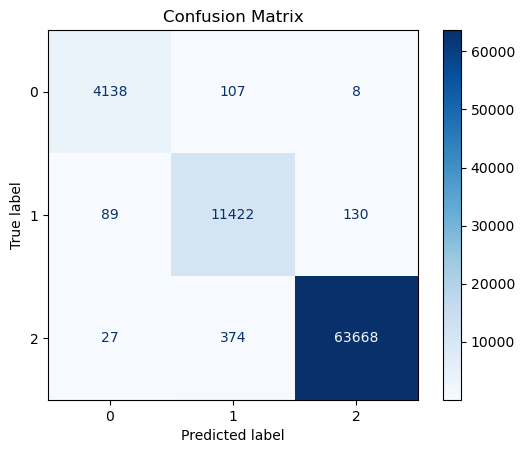

07 : 0.97963


c:\Users\erich\anaconda3\envs\CustomerSegment\lib\site-packages\xgboost\core.py:158: UserWarning: [16:39:36] WARNING: D:\bld\xgboost-split_1742444198260\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-mlogloss:0.96117


KeyboardInterrupt: 

In [7]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import compute_class_weight

import xgboost as xgb
import matplotlib.pyplot as plt


models = []
y_preds = []
idx = 7

importance_df = None  # 중요도 DataFrame 초기화

# 첫 번째 train으로 split 인덱스를 생성
first_train = trains[0]
X = first_train.drop("Segment", axis=1)
y = first_train["Segment"]
X_train_idx, X_test_idx = train_test_split(X.index, test_size=0.2, 
                                           random_state=42, stratify=y)

print("===== Macro F1 Score =====")

for train in trains:
    train_X = train.drop("Segment", axis=1)
    train_y = train["Segment"]

    X_train = train_X.loc[X_train_idx]
    X_test = train_X.loc[X_test_idx]
    y_train = train_y.loc[X_train_idx]
    y_test = train_y.loc[X_test_idx]

    num_classes = y_train.nunique()

    # 클래스별 가중치 계산
    class_weights = compute_class_weight(class_weight='balanced',
                                         classes=np.unique(y_train),
                                         y=y_train)
    class_weight_dict = {cls: weight for cls, weight in zip(np.unique(y_train), class_weights)}

    # 각 샘플에 대해 가중치 부여
    sample_weight = y_train.map(class_weight_dict)

    model = xgb.XGBClassifier(
        objective='multi:softmax',
        num_class=num_classes,
        eval_metric='mlogloss',
        use_label_encoder=False,
        random_state=random_state,
        n_estimators=300,
        learning_rate=0.1,
        max_depth=6
    )

    # 모델 학습 (sample_weight 적용)
    model.fit(X_train, y_train,
              sample_weight=sample_weight,
              eval_set=[(X_test, y_test)],
              verbose=50)

    # 예측
    y_pred = model.predict(X_test)
    y_preds.append(y_pred)

    # 혼동 행렬 출력
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()

    # 중요도 처리 동일
    score_dict = model.get_booster().get_score(importance_type='gain')
    score_series = pd.Series(score_dict, name=f'model_{idx - 6}_importance')

    if importance_df is None:
        features = model.get_booster().feature_names
        importance_df = pd.DataFrame({'feature': features})

    score_df = score_series.reset_index()
    score_df.columns = ['feature', f'month_{idx:02}_importance']
    importance_df = importance_df.merge(score_df, on='feature', how='left')

    models.append(model)

    score = f1_score(y_test, y_pred, average='macro')
    print(f"{idx:02} : {round(score, 5)}")

    idx += 1

# NaN 처리 및 중요도 정리
importance_df.fillna(0, inplace=True)
importance_df['total_importance'] = importance_df.filter(like='month_').sum(axis=1)

In [29]:
importance_df.sort_values(by='total_importance', ascending=False, inplace=True)
importance_df.head(20)

,feature,month_07_importance,month_08_importance,month_09_importance,month_10_importance,month_11_importance,month_12_importance,total_importance
57,RV신청일자,26.154638,30.014217,32.577190,26.009645,24.481482,15.481849,154.719022
343,최종카드론_대출금액,3.188777,0.000000,9.675611,9.668018,9.668018,0.000000,32.200424
333,최초카드론이용경과월,0.000000,29.991598,0.000000,0.000000,0.000000,0.000000,29.991598
773,증감율_이용건수_일시불_분기,0.000000,26.289534,0.000000,0.000000,0.000000,0.000000,26.289534
340,최종카드론_대출일자,2.078734,2.666576,3.316737,3.693468,4.364147,9.127144,25.246806
87,rv최초시작후경과일,4.060164,0.000000,2.574982,0.000000,0.000000,13.051838,19.686984
49,카드이용한도금액,1.225523,1.345397,0.623298,2.348113,1.979090,8.675108,16.196529
792,잔액_신판ca최대한도소진율_r3m,0.000000,0.000000,0.000000,0.000000,0.000000,13.978616,13.978616
76,카드이용한도금액_B2M,0.569552,2.241159,1.290324,0.000000,2.859767,5.481970,12.442773
75,카드이용한도금액_B1M,2.660586,0.781041,0.085065,1.641792,2.790904,3.460443,11.419830


In [24]:
list(importance_df[importance_df["total_importance"] == 0]["feature"])

['IB문의건수_분실도난_B0M',
 'IB문의건수_SMS_B0M',
 'IB문의건수_결제_B0M',
 'IB문의건수_CA_B0M',
 'IB문의건수_BL_B0M',
 '연체잔액_B0M',
 'IB문의건수_명세서_B0M',
 'IB문의건수_APP_B0M',
 'IB문의건수_부대서비스_B0M',
 'IB문의건수_비밀번호_B0M',
 'IB문의건수_할부_B0M',
 'IB문의건수_정보변경_B0M',
 'IB문의건수_결제일변경_B0M',
 '연체잔액_카드론_B0M',
 'IB문의건수_카드발급_B0M',
 '연체잔액_할부_B0M',
 '연체잔액_현금서비스_B0M',
 'IB문의건수_포인트_B0M',
 '연체잔액_일시불_B0M',
 '월중평잔_할부',
 'IB문의건수_CL_RV_B0M',
 '연체일자_B0M',
 'IB문의건수_APP_R6M',
 'IB문의건수_부대서비스_R6M',
 'IB문의건수_포인트_R6M',
 'IB문의건수_카드발급_R6M',
 'IB문의건수_BL_R6M',
 'IB문의건수_분실도난_R6M',
 'IB문의건수_CA_R6M',
 'IB문의건수_CL_RV_R6M',
 'IB문의건수_CS_R6M',
 'IB상담건수_VOC_R6M',
 'IB상담건수_VOC민원_R6M',
 'IB상담건수_VOC불만_R6M',
 'IB상담건수_금감원_R6M',
 '불만제기건수_B0M',
 '불만제기건수_R12M',
 '불만제기후경과월_R12M',
 '당사PAY_방문횟수_B0M',
 '당사PAY_방문횟수_R6M',
 '당사PAY_방문월수_R6M',
 'IB문의건수_SMS_R6M',
 'IB문의건수_비밀번호_R6M',
 'IB문의건수_명세서_R6M',
 '상담건수_R6M',
 'IB문의건수_CS_B0M',
 'IB상담건수_VOC_B0M',
 '카드론잔액_최종경과월',
 '월중평잔_할부_B0M',
 '월중평잔_일시불_B0M',
 'IB상담건수_VOC민원_B0M',
 'IB문의건수_선결제_B0M',
 'IB상담건수_금감원_B0M',
 'IB문의건수_사용승인내역_R6M',
 'IB

### 앙상블

In [25]:
preds = []

for train, model in zip(trains, models):
    train_X = train.drop("Segment", axis=1)
    train_y = train["Segment"]

    X_train = train_X.loc[X_train_idx]
    X_test = train_X.loc[X_test_idx]
    y_train = train_y.loc[X_train_idx]
    y_test = train_y.loc[X_test_idx]

    pred = model.predict_proba(X_test)
    preds.append(pred)

    # 확률 평균
    ensemble_preds = np.mean(preds, axis=0)

    # 최종 클래스 예측
    final_preds = np.argmax(ensemble_preds, axis=1)


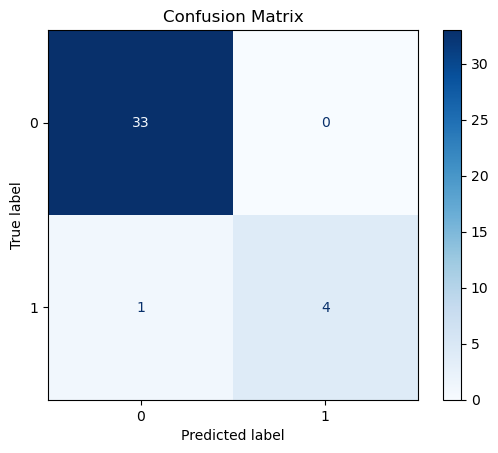

In [ ]:
# confusion matrix 계산
cm = confusion_matrix(y_test, final_preds)

# 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')  # 색상은 보기 좋게 파란색 계열
plt.title("Confusion Matrix")
plt.show()

In [28]:
score = f1_score(y_test, final_preds, average='macro')
print(f"{idx:02} : {round(score, 5)}")

13 : 0.93698
